Датасет **tmdb_data** содержит информацию о фильмах, собранную с платформы TMDB

- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `production_countries` - список стран, учавствовавших в производстве фильма

Датасет **cpi_data** содержит информацию о значении cpi на каждый месяц с 1913 года

- `cpi_date` - дата (ГГГГ-ММ-01)
- `cpi` - значение cpi

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [3]:
pd.options.display.float_format='{:.2f}'.format
pd.set_option('display.max_columns', None)

- Загружаем датасеты, оставляя необходимые столбцы 
- Преобразовываем типы данных (`year` в датасете cpi_data и `release_date` в tmdb_data)
- Переименовываем столбец `year` в датасете cpi_data на `cpi_date`

In [4]:
columns_tmdb = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries"   
]

In [5]:
df_tmdb = pd.read_csv(
    '../data/raw/tmdb_data.csv',
    usecols=columns_tmdb,
    parse_dates=['release_date']
    )
df_cpi = pd.read_csv(
    '../data/raw/cpi_data.csv',
    parse_dates=['year']
    ).rename(columns={'year': 'cpi_date'})

In [6]:
df_cpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   cpi_date  1349 non-null   datetime64[ns]
 1   cpi       1349 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.2 KB


In [7]:
print(f'''Датасет df_cpi состоит из:
- {df_cpi.shape[0]} строк
- {df_cpi.shape[1]} столбцов''')

Датасет df_cpi состоит из:
- 1349 строк
- 2 столбцов


In [8]:
df_cpi.head(3)

,cpi_date,cpi
0,1913-01-01,9.80
1,1913-02-01,9.80
2,1913-03-01,9.80


- Объявляем переменную **latest_cpi**, которая будет хранить информацию о последнем зафиксированном значении cpi

In [9]:
latest_cpi = df_cpi.loc[df_cpi['cpi_date'].idxmax(), 'cpi']
print(f'Значение актуального CPI = {latest_cpi}')

Значение актуального CPI = 321.465


In [10]:
df_tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245680 entries, 0 to 1245679
Data columns (total 10 columns):
 #   Column                Non-Null Count    Dtype         
---  ------                --------------    -----         
 0   id                    1245680 non-null  int64         
 1   title                 1245667 non-null  object        
 2   vote_average          1245680 non-null  float64       
 3   release_date          1010440 non-null  datetime64[ns]
 4   revenue               1245680 non-null  int64         
 5   budget                1245680 non-null  int64         
 6   original_language     1245680 non-null  object        
 7   original_title        1245667 non-null  object        
 8   genres                724614 non-null   object        
 9   production_countries  670517 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 95.0+ MB


In [11]:
print(f'''Датасет df_tmdb состоит из:
- {df_tmdb.shape[0]} строк
- {df_tmdb.shape[1]} столбцов''')

Датасет df_tmdb состоит из:
- 1245680 строк
- 10 столбцов


- Сохраняем в переменную **old_rows** данные о количестве строк в датасете с фильмами до предобработки, чтобы позже оценить количество удаленной информации

In [12]:
old_rows = df_tmdb.shape[0]
old_rows

1245680

### Смена типов данных

In [13]:
df_tmdb.dtypes

id                               int64
title                           object
vote_average                   float64
release_date            datetime64[ns]
revenue                          int64
budget                           int64
original_language               object
original_title                  object
genres                          object
production_countries            object
dtype: object

Типы данных корректны

- Преобразуем содержимое строковых данных к нижнему регистру, чтобы избежать возможных дубликатов

In [14]:
str_column = df_tmdb.select_dtypes(include='object').columns
for col in str_column:
    df_tmdb[col] = df_tmdb[col].str.lower().str.strip()
df_tmdb[str_column].head(3)

,title,original_language,original_title,genres,production_countries
0,inception,en,inception,"action, science fiction, adventure","united kingdom, united states of america"
1,interstellar,en,interstellar,"adventure, drama, science fiction","united kingdom, united states of america"
2,the dark knight,en,the dark knight,"drama, action, crime, thriller","united kingdom, united states of america"


### Объединяем датафреймы

- Объединяем df_tmdb и df_cpi по дате начала месяца. Для этого добавим новый столбец в df_tmdb, который приведет release_date к началу месяца

In [15]:
df_tmdb['release_month'] = (df_tmdb['release_date']
                            .dt.to_period('M')
                            .dt.to_timestamp()
                            )
df_tmdb['release_month'].head(2)

0   2010-07-01
1   2014-11-01
Name: release_month, dtype: datetime64[ns]

In [16]:
df_merged = df_tmdb.merge(df_cpi,
                          left_on='release_month',
                          right_on='cpi_date',
                          how='inner')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998462 entries, 0 to 998461
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    998462 non-null  int64         
 1   title                 998458 non-null  object        
 2   vote_average          998462 non-null  float64       
 3   release_date          998462 non-null  datetime64[ns]
 4   revenue               998462 non-null  int64         
 5   budget                998462 non-null  int64         
 6   original_language     998462 non-null  object        
 7   original_title        998458 non-null  object        
 8   genres                667926 non-null  object        
 9   production_countries  632466 non-null  object        
 10  release_month         998462 non-null  datetime64[ns]
 11  cpi_date              998462 non-null  datetime64[ns]
 12  cpi                   998462 non-null  float64       
dtyp

### Проверка на дубликаты

In [17]:
print(f'Найдено {df_merged.duplicated().sum()} полных дубликатов строк')

Найдено 169 полных дубликатов строк


- удаляем их

In [18]:
df_merged = df_merged.drop_duplicates().reset_index(drop=True)
df_merged.duplicated().sum()

np.int64(0)

- Проверим, есть ли дубликаты по столбцам с информацией об оригинальном названии фильма и датой релиза

In [19]:
print(f'''Найдено {df_merged[['original_title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 1990 дубликатов


- Фильмы с одинаковым оригинальным названием и одинаковой датой релиза могут указывать на дубликаты - удаляем их

In [20]:
df_merged = df_merged.drop_duplicates(subset=['original_title', 'release_date'])
df_merged = df_merged.reset_index(drop=True)

Одинаковые названия фильмов действительно могут встречаться - главное, чтобы даты релизов не совпадали

- Теперь проверим дубликаты, связанные с англоязычным названием и датой релиза

In [21]:
print(f'''Найдено {df_merged[['title', 'release_date']].duplicated().sum()} дубликатов''')

Найдено 345 дубликатов


In [22]:
df_merged[df_merged.duplicated(subset=['title', 'release_date'], keep=False)][['title', 'release_date']].value_counts()

title                       release_date
chosen 2                    2020-01-13      3
fatal love                  1993-01-01      3
8 seconds                   1994-02-25      2
resurrection of love        1973-01-01      2
run!                        2013-10-23      2
                                           ..
golmorich                   2021-02-14      2
god's gift                  1998-01-01      2
girls                       2014-07-30      2
ghost story of kam pin mui  1991-06-22      2
zhanxiou village            2007-05-20      2
Name: count, Length: 343, dtype: int64

Проверим фильм  `chosen 2`, чтобы понять, стоит ли нам считать совпадение по дате релиза и англоязычному названию - дубликатами

In [23]:
df_merged[df_merged['title'] == 'chosen 2']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
472103,1160180,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅰ救赎,NaN,NaN,2020-01-01,2020-01-01,257.97
472133,1160183,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅱ同盟,NaN,NaN,2020-01-01,2020-01-01,257.97
472135,1160184,chosen 2,0.00,2020-01-13,0,0,en,杀无赦2：ⅲ重生,NaN,NaN,2020-01-01,2020-01-01,257.97


In [24]:
df_merged[df_merged['title'] == 'zhanxiou village']

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
475737,1405386,zhanxiou village,0.00,2007-05-20,0,0,zh,朱辛庄,NaN,china,2007-05-01,2007-05-01,207.95
510530,1469333,zhanxiou village,0.00,2007-05-20,0,0,en,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95
563559,1264836,zhanxiou village,0.00,2007-05-15,0,0,fr,zhanxiou village,NaN,NaN,2007-05-01,2007-05-01,207.95


- Оригинальные названия разные, судя по всему, это могут быть разные части одного проекта, релизнутые в один день. 

Совпадения по дате релиза и англоязычному названию НЕ указывают на дубликаты

In [25]:
new_rows = df_merged.shape[0]
print(f'''Было удалено {old_rows - new_rows} строк.
Мы лишились {round((old_rows - new_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 249377 строк.
Мы лишились 20.02% данных


### Анализ пропусков

In [26]:
df_merged.isnull().sum().sort_values(ascending=False)

production_countries    364693
genres                  329685
title                        4
original_title               4
id                           0
vote_average                 0
release_date                 0
revenue                      0
budget                       0
original_language            0
release_month                0
cpi_date                     0
cpi                          0
dtype: int64

In [27]:
(df_merged.isnull().mean() * 100).sort_values(ascending=False).round(2)

production_countries   36.60
genres                 33.09
title                   0.00
original_title          0.00
id                      0.00
vote_average            0.00
release_date            0.00
revenue                 0.00
budget                  0.00
original_language       0.00
release_month           0.00
cpi_date                0.00
cpi                     0.00
dtype: float64

У нас отсутствует свыше 40% информации по странам производства и жанрам. Также есть пропуски в 17% информации о дате релиза, 18% пропусков по информации о cpi.


- Данные CPI у нас есть с 1913 года, поэтому исключим фильмы, для которых не определено CPI

In [28]:
df_merged = df_merged[df_merged['cpi'].notna()].reset_index(drop=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 996303 entries, 0 to 996302
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   id                    996303 non-null  int64         
 1   title                 996299 non-null  object        
 2   vote_average          996303 non-null  float64       
 3   release_date          996303 non-null  datetime64[ns]
 4   revenue               996303 non-null  int64         
 5   budget                996303 non-null  int64         
 6   original_language     996303 non-null  object        
 7   original_title        996299 non-null  object        
 8   genres                666618 non-null  object        
 9   production_countries  631610 non-null  object        
 10  release_month         996303 non-null  datetime64[ns]
 11  cpi_date              996303 non-null  datetime64[ns]
 12  cpi                   996303 non-null  float64       
dtyp

Кажется, что в столбце бюджета и дохода пропусков нет, однако там пропущенные значения могут обозначаться как 0

In [29]:
df_merged['budget'].value_counts()

budget
0          946214
100          1580
1000         1411
10000        1315
500          1223
            ...  
1297000         1
713965          1
1201000         1
686165          1
411             1
Name: count, Length: 5341, dtype: int64

### Анализ REVENUE

In [30]:
def millions(x, pos):
    '''Функция используется с FuncFormat 
    для форматирования значения x в миллионах 
    с округлением до одного знака после запятой'''
    return f'{x * 1e-6:.1f}'

In [31]:
df_merged['revenue'].value_counts()

revenue
0           976854
100            356
1              319
1000           166
10             165
             ...  
53672080         1
26527510         1
74918            1
26576000         1
2748000          1
Name: count, Length: 14118, dtype: int64

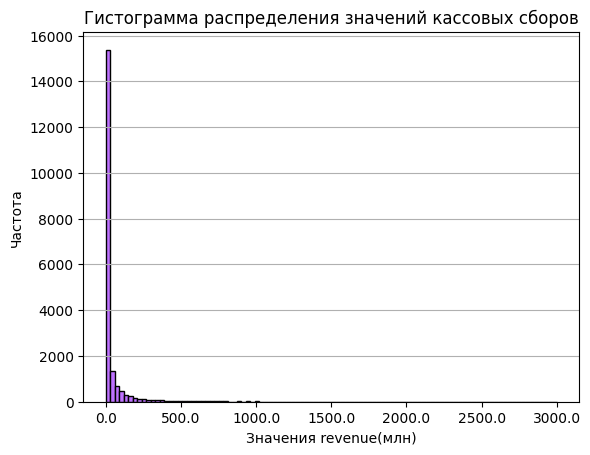

In [32]:
plt.hist(df_merged[df_merged['revenue'] > 0]['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Значения revenue(млн)')
plt.ylabel('Частота')

plt.show()

Большая часть данных хранит в себе значение "0" в столбце кассовых сборов (доходов). 

In [33]:
df_merged['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,996303.00,763530.83,18594952.76,-12.00,0.00,0.00,0.00,3000000000.00


Высокое значение стандартного отклонения указывает на большой разброс данных - есть выбросы. Учитывая, что 75-й квантиль равен 0, можно сделать вывод - большинство данных не имеют информации о кассовых сборах  

In [34]:
print(f'''Ненулевых значений обнаружено - {df_merged[df_merged['revenue'] > 0]['revenue'].count()}''')

Ненулевых значений обнаружено - 19448


- Объявим переменную, которая будет хранить булевую маску со значениями, где кассовые сборы были больше 0

In [35]:
filter_not_zero = df_merged['revenue'] > 0
filter_not_zero.head(3)

0    True
1    True
2    True
Name: revenue, dtype: bool

- Объявим переменные, которые будут хранить значения 30-го и 99-го квантиля

In [36]:
quantile_min = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.3)
print(f'''Значение 30-го процентиля = {quantile_min.round(2)}''')

Значение 30-го процентиля = 162858.7


In [37]:
quantile_max = df_merged.loc[filter_not_zero, 'revenue'].quantile(0.99)
print(f'''Значение 99-го процентиля = {quantile_max.round(2)}''')

Значение 99-го процентиля = 626172440.88


Отфильтруем наш датасет по значениям от 30-го квантиля до 99-го, чтобы избавиться от аномальных значений 

In [38]:
df_filtered = df_merged[(df_merged['revenue'] > quantile_min) & (df_merged['revenue'] < quantile_max)]
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82


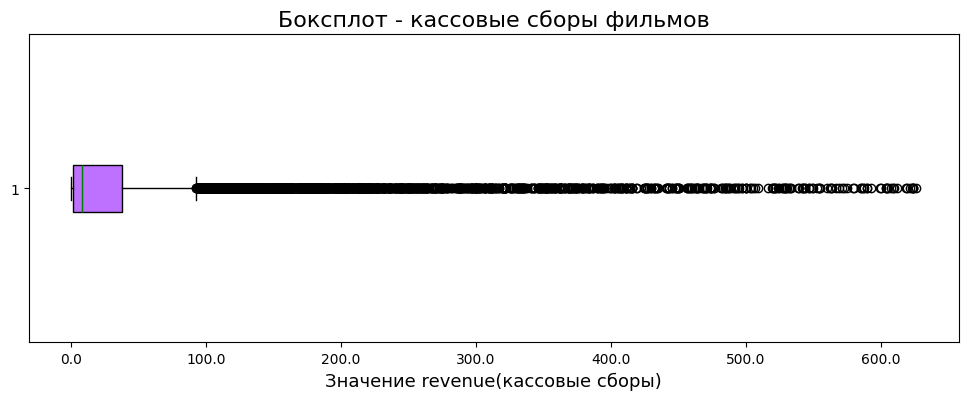

In [39]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['revenue'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))

plt.title('Боксплот - кассовые сборы фильмов', fontsize=16)
plt.xlabel('Значение revenue(кассовые сборы)', fontsize=13)

plt.show()

На боксплоте видно, что все аномальные значения находятся справа - их довольно много. 
Это бестселлеры, которые действительно получили огромные кассовые сборы

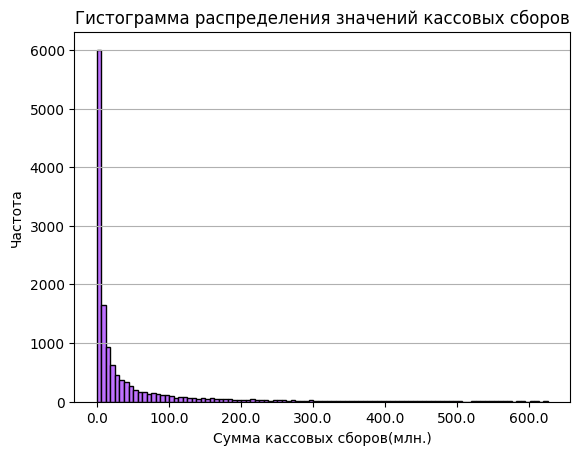

In [40]:
plt.hist(df_filtered['revenue'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения значений кассовых сборов')
plt.xlabel('Сумма кассовых сборов(млн.)')
plt.ylabel('Частота')

plt.show()

In [41]:
df_filtered['revenue'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
revenue,13418.00,42280627.29,84593540.76,163000.00,1775969.25,8638117.50,38290049.25,626137675.00


In [42]:
filtered_rows = df_filtered.shape[0]
print(f'''Было удалено {old_rows - filtered_rows} строк.
Мы лишились {round((old_rows - filtered_rows)
            / old_rows * 100, 2)}% данных''')

Было удалено 1232262 строк.
Мы лишились 98.92% данных


### Анализ BUDGET

In [43]:
print(f'''{df_filtered[df_filtered['budget'] == 0].shape[0]} количество фильмов не содержат информации о бюджете ''')

4388 количество фильмов не содержат информации о бюджете 


In [44]:
print(f'''{df_filtered[df_filtered['budget'] > 0].shape[0]} количество фильмов содержат информацию о бюджете''')

9030 количество фильмов содержат информацию о бюджете


In [45]:
df_filtered['budget'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
budget,13418.00,15734926.22,30054411.30,0.00,0.00,3000000.00,18572000.00,645654654.00


Мы видим большое стандратное отклонение, которое указывает на выбросы. У 25% фильмов отсутсвует информация о бюджете

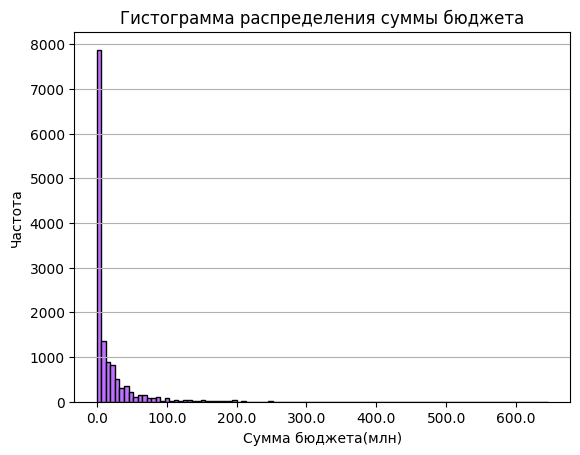

In [46]:
plt.hist(df_filtered['budget'],
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.grid(axis='y')

plt.title('Гистограмма распределения суммы бюджета')
plt.xlabel('Сумма бюджета(млн)')
plt.ylabel('Частота')


plt.show()

- Распределение сильно смещено вправо: встречаются редкие, но очень крупные бюджеты
- Около 25% фильмов имеют нулевой бюджет, это значит, что данные либо отсутствуют - это типичная ситуация для фильмов, финансируемых: государственными субсидиями, международными фондами, кинокомиссиями.

По этой причине нулевые значения мы оставляем 

### Анализ PRODUCTION_COUNTRIES

In [47]:
df_filtered['production_countries'].value_counts()

production_countries
united states of america                                            5866
india                                                                703
united kingdom, united states of america                             419
japan                                                                412
united kingdom                                                       330
                                                                    ... 
belgium, france, canada                                                1
switzerland, france                                                    1
united states of america, united kingdom, germany, japan, france       1
czech republic, france, germany                                        1
kazakhstan                                                             1
Name: count, Length: 1134, dtype: int64

In [48]:
df_filtered.head(3)

,id,title,vote_average,release_date,revenue,budget,original_language,original_title,genres,production_countries,release_month,cpi_date,cpi
7,550,fight club,8.44,1999-10-15,100853753,63000000,en,fight club,drama,united states of america,1999-10-01,1999-10-01,168.20
9,680,pulp fiction,8.49,1994-09-10,213900000,8500000,en,pulp fiction,"thriller, crime",united states of america,1994-09-01,1994-09-01,149.40
12,1726,iron man,7.64,2008-04-30,585174222,140000000,en,iron man,"action, science fiction, adventure",united states of america,2008-04-01,2008-04-01,214.82


В данных по странам производства присутствуют строки с несколькими странами. Будем брать первую страну из списка, так как чаще всего именно она отражает основную страну производства. Такой подход соответствует распространённой практике в исследовательских работах и научных публикациях, где при множественном указании стран приоритет отдаётся первой по порядку как представителю основного продюсера проекта.

In [49]:
df_filtered['main_country'] = (
                                df_filtered['production_countries']
                               .str.split(',', expand=True)[0]
                               )

/tmp/ipykernel_4456/1004472657.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['main_country'] = (


In [50]:
df_country = df_filtered['main_country'].value_counts(ascending=True).reset_index()
df_country.head(2)

,main_country,count
0,kazakhstan,1
1,lebanon,1


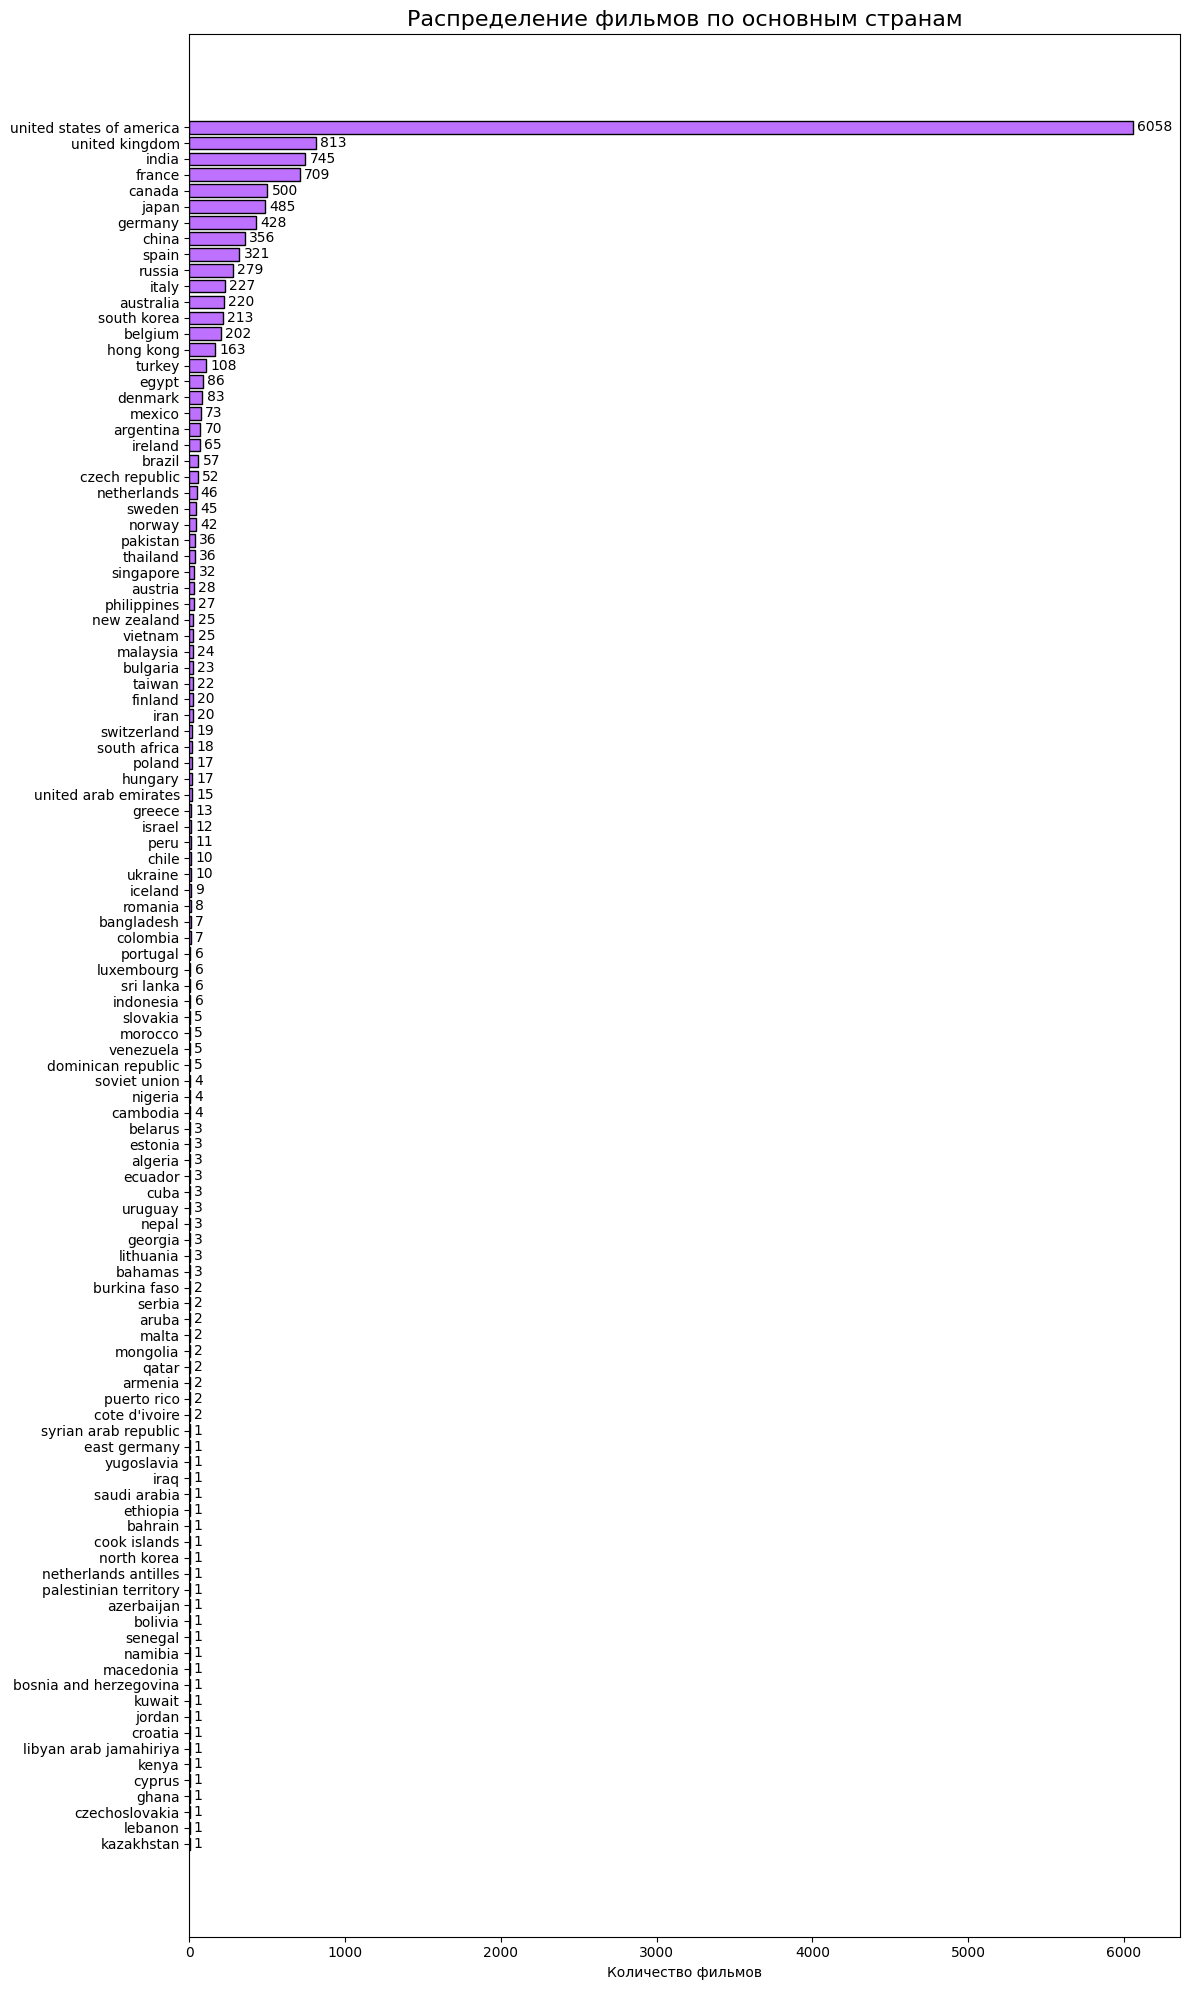

In [51]:
plt.figure(figsize=(12, 20))

bars = plt.barh(
    y=df_country['main_country'],
    width=df_country['count'],
    color='#be71ff',
    edgecolor='black'
)

plt.gca().bar_label(bars, fmt='%.0f', padding=3)

plt.xlabel('Количество фильмов')
plt.title('Распределение фильмов по основным странам', fontsize=16)
plt.tight_layout()
plt.show()

### Анализ VOTE_AVERTAGE

In [52]:
df_filtered['vote_average'].value_counts()

vote_average
0.00    387
6.00    224
7.00    150
6.50    139
6.20    129
       ... 
8.18      1
4.33      1
3.15      1
4.87      1
8.44      1
Name: count, Length: 3270, dtype: int64

У нас действительно могут встречаться фильмы без оценок пользователей, так что тут значение 0 не критично

In [53]:
df_filtered['vote_average'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
vote_average,13418.00,6.18,1.47,0.00,5.74,6.39,7.00,10.00


Стандартное отклонение не критичное, а значит вариативность умеренная

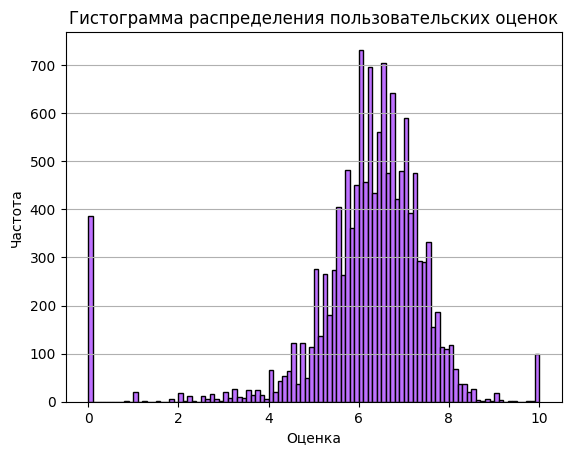

In [54]:
plt.hist(df_filtered['vote_average'], 
         bins=100,
         color='#be71ff',
         edgecolor='black')

plt.grid(axis='y')

plt.title('Гистограмма распределения пользовательских оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

plt.show()

- Распределение с левосторонней ассиметрией
- Вытянутый левый хвост обусловлен наличием свыше 900 нулевых оценок

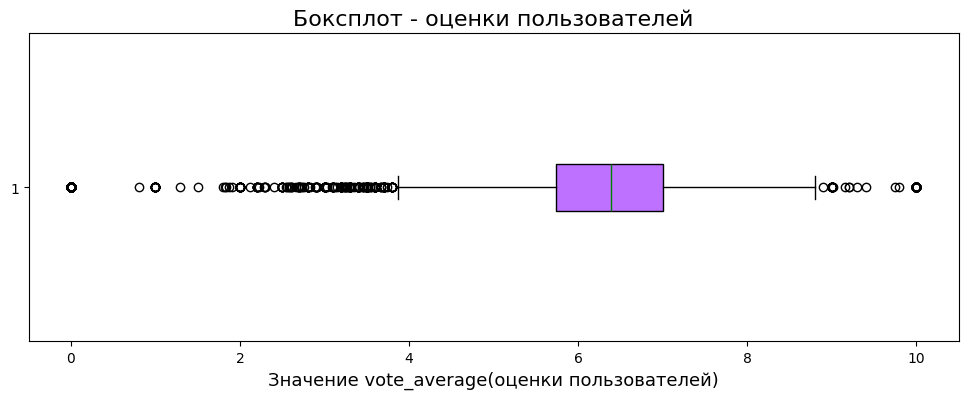

In [55]:
plt.figure(figsize=(12, 4))
plt.boxplot(df_filtered['vote_average'],
            vert=False,
            patch_artist=True,
            boxprops=dict(facecolor='#be71ff', color='black'),
            medianprops=dict(color='green'))

plt.title('Боксплот - оценки пользователей', fontsize=16)
plt.xlabel('Значение vote_average(оценки пользователей)', fontsize=13)

plt.show()

- Основная часть оценок приходится на значения ~5.6-6.97. Слева у нас наблюдается много выбросов, справа выбросы тоже есть, но их меньше. 
- Низкая оценка, как и ее отсутствие, может быть связана с малой популярностью фильма, возможно даже полным отсутствием популярности. 
- Высокая оценка может быть связана с большой положительной популярностью фильма, а также присутствует и такой вариант, что фильм не особо известен, у него не так много оценок - но все высокие. Тогда наша средняя оценка сильно завышается

### Уникальные значения

- Уникальные значения в жанрах

In [56]:
df_filtered['genres'].value_counts()

genres
drama                                            997
comedy                                           918
drama, romance                                   487
comedy, drama                                    425
comedy, romance                                  410
                                                ... 
war, action, history, thriller                     1
mystery, drama, thriller, comedy                   1
family, comedy, adventure, animation, fantasy      1
adventure, action, fantasy, war, history           1
drama, family, documentary                         1
Name: count, Length: 2332, dtype: int64

- У нас встречаются строки с перечислением нескольких жанров. Для нашего исследования мы оставляем их в исходном виде. При построении дашборда предполагается использовать проверку по жанрам через оператор LIKE (SQL)

In [57]:
print(f'''У {df_filtered['genres'].isnull().sum()} фильмов отсутствует информация о жанрах''')

У 93 фильмов отсутствует информация о жанрах


- Нулевые значения можно заменить на "undefined"

In [58]:
df_filtered['genres'] = df_filtered['genres'].fillna('undefined')

/tmp/ipykernel_4456/3432640581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['genres'] = df_filtered['genres'].fillna('undefined')


In [59]:
df_filtered['genres'].value_counts()

genres
drama                                            997
comedy                                           918
drama, romance                                   487
comedy, drama                                    425
comedy, romance                                  410
                                                ... 
war, action, history, thriller                     1
mystery, drama, thriller, comedy                   1
family, comedy, adventure, animation, fantasy      1
adventure, action, fantasy, war, history           1
drama, family, documentary                         1
Name: count, Length: 2333, dtype: int64

Изучим уникальные данные по столбцу с original_language

In [60]:
df_tmdb['original_language'].value_counts()

original_language
en    677118
fr     72866
es     63811
de     58003
ja     54597
       ...  
kv         1
ee         1
ik         1
os         1
ii         1
Name: count, Length: 176, dtype: int64

- Пропуски отсутствуют - данные выглядят полными

### Учет инфляции 

Добавим два столбца:
- `current_budget` - бюджет с учетом инфляции
- `current_revenue` - кассовые сборы с учетом инфляции

In [61]:
df_filtered['current_budget'] = (
    df_filtered['budget'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['budget', 'current_budget']].head(3)

/tmp/ipykernel_4456/4200148618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_budget'] = (


,budget,current_budget
7,63000000,120406034.48
9,8500000,18289508.03
12,140000000,209498517.38


In [62]:
df_filtered['current_revenue'] = (
    df_filtered['revenue'] * (latest_cpi / df_filtered['cpi'])
)
df_filtered[['revenue', 'current_revenue']].head(3)

/tmp/ipykernel_4456/3040352102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['current_revenue'] = (


,revenue,current_revenue
7,100853753,192752388.28
9,213900000,460250090.36
12,585174222,875665228.00


### Итог 

In [63]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13418 entries, 7 to 995587
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13418 non-null  int64         
 1   title                 13418 non-null  object        
 2   vote_average          13418 non-null  float64       
 3   release_date          13418 non-null  datetime64[ns]
 4   revenue               13418 non-null  int64         
 5   budget                13418 non-null  int64         
 6   original_language     13418 non-null  object        
 7   original_title        13418 non-null  object        
 8   genres                13418 non-null  object        
 9   production_countries  13068 non-null  object        
 10  release_month         13418 non-null  datetime64[ns]
 11  cpi_date              13418 non-null  datetime64[ns]
 12  cpi                   13418 non-null  float64       
 13  main_country        

In [64]:
columns_to_keep = [
    "id",
    "title",                 
    "original_title",        
    "original_language",     
    "release_date",          
    "genres",                
    "budget",                
    "revenue",               
    "vote_average",          
    "production_countries",
    "cpi", 
    "current_budget",
    "current_revenue"  
]

In [65]:
df_filtered = df_filtered[columns_to_keep].copy()
df_filtered = df_filtered.reset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13418 entries, 0 to 13417
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    13418 non-null  int64         
 1   title                 13418 non-null  object        
 2   original_title        13418 non-null  object        
 3   original_language     13418 non-null  object        
 4   release_date          13418 non-null  datetime64[ns]
 5   genres                13418 non-null  object        
 6   budget                13418 non-null  int64         
 7   revenue               13418 non-null  int64         
 8   vote_average          13418 non-null  float64       
 9   production_countries  13068 non-null  object        
 10  cpi                   13418 non-null  float64       
 11  current_budget        13418 non-null  float64       
 12  current_revenue       13418 non-null  float64       
dtypes: datetime64[ns

In [66]:
df_filtered['release_date'].min()


Timestamp('1913-11-24 00:00:00')

In [67]:
print(f'''Наш отфильтрованный и предобработанный датасет состоит из:
- {df_filtered.shape[0]} строк
- {df_filtered.shape[1]} столбцов''')

Наш отфильтрованный и предобработанный датасет состоит из:
- 13418 строк
- 13 столбцов




- `id` - уникальный идентификатор фильма
- `title` - англоязычное название фильма
- `original_title` - оригинальное название фильма
- `original_language` - язык оригинала
- `release_date` - дата выхода фильма
- `genres` - жанры фильма
- `budget` - бюджет фильма (в долларах)
- `revenue` - кассовые сборы, доход (в долларах)
- `vote_average` - рейтинг фильма, основанный на пользовательских голосах
- `main_country` - главная страна, учавствовавшая в производстве фильма
- `cpi` - cpi на дату выхода фильма
- `latest_cpi` - актуальный cpi
- `current_budget` - сумма бюджета с учетом инфляции
- `current_revenue` - сумма кассовых сборов с учетом инфляции

 ## Графики (примеры + могут дополняться)

**scatter plot - corrent_revenue vs vote_average**


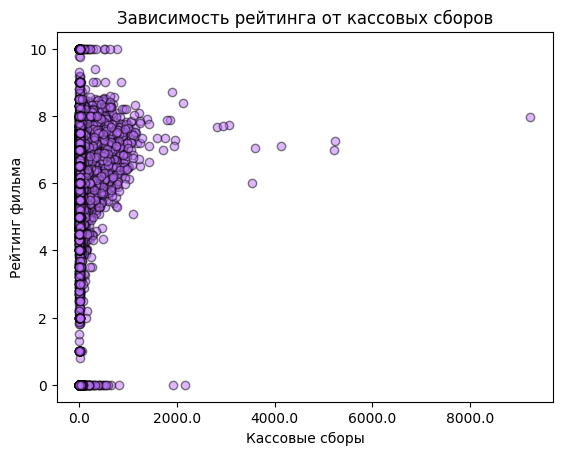

In [68]:
plt.scatter(
    df_filtered['current_revenue'],
    df_filtered['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Уберем выбросы

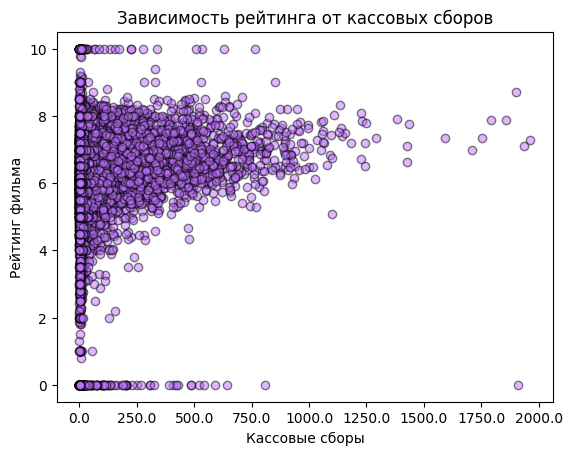

In [69]:
plt.scatter(
    df_filtered[df_filtered['current_revenue'] < 2000000000]['current_revenue'],
    df_filtered[df_filtered['current_revenue'] < 2000000000]['vote_average'],
    alpha=0.5,
    color='#be71ff',
    edgecolors='black'
)
plt.gca().xaxis.set_major_formatter(FuncFormatter(millions))
plt.title('Зависимость рейтинга от кассовых сборов')
plt.xlabel('Кассовые сборы')
plt.ylabel('Рейтинг фильма')
plt.show()

- Большинство фильмов имеют относительно низкие сборы, вне зависимости от рейтинга.
- Высокие сборы - чаще высокие рейтинги. На графике видно, что с увеличением значения кассовых сборов, фильмов становится меньше, однако рейтинг у них держится в районе 6-9.

**Линейный график - кол-во фильмов**

In [70]:
df_filtered['year'] = pd.to_datetime(df_filtered['release_date']).dt.year

In [71]:
films_year = df_filtered['year'].value_counts()
films_year = films_year.reset_index(drop=False)
films_year = films_year.sort_values(by='year')
films_year.head()

,year,count
108,1913,1
106,1914,2
111,1915,1
102,1916,3
105,1918,2


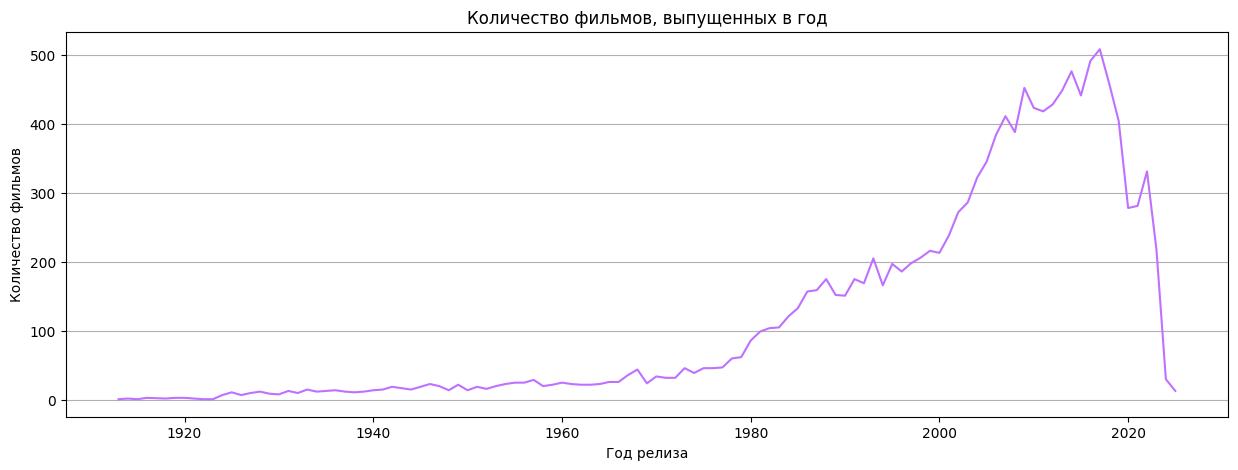

In [72]:
plt.figure(figsize=(15, 5))

plt.plot(films_year['year'],
         films_year['count'],
          color='#be71ff')

plt.title('Количество фильмов, выпущенных в год')
plt.xlabel('Год релиза')
plt.ylabel('Количество фильмов')
plt.grid(axis='y')
plt.show()

продолжение следует...

In [73]:
df_filtered['production_countries'].str.contains("russia").count()

np.int64(13068)